# Hydroroot model

Definition of the prameters

In [6]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/home/fabrice/Documents/hydroroot', '/home/fabrice/Documents/hydroroot/src', '/home/fabrice/Documents/hydroroot/test', '/home/fabrice/Documents/hydroroot/example'])
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Python 2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)] on linux2


Architectural parameters
------------------------
  - $n$ : number of nodes in primary root 
  - $\delta$: reference distance between successive branching axis
  - $\beta$ : branching variability or Number of nodes between successive ramification
  - $order_{max}$ : maximum order of ramification
  - $\lambda$ : nude tip length
  - $radius$ : external radius of the main axis of the root
  - $\alpha$ : order decrease factor : $r_{order} = radius*{\alpha}^{order}$

In [8]:
primary_length = 0.15
n = 1100
delta = 20
beta = 0.25 # 25 %
order_max = 5
segment_length = 1e-4
nude_length = 200
seed = 2

ref_radius = 1e-4 # in m
order_decrease_factor = 0.7

Conductance and model Parameters
=================================

  - $k_0$: radial conductivity
  - $K$ :axial conductivity (computed from xylem vessels)
  - $J_v$: Observed or calculated flow t the root base (hypocotyl)
  - $\psi_e$: external solution water potential 
  - $\psi_{base}$ : water potential at the hypocotyl
  
  

In [9]:
# parameters
k0 = 300
Jv = 0.1
psi_e = 0.4
psi_base = 0.1

### Define a length law that describe the length of ramification along the axis lentgh

In [10]:
from openalea.core.path import path
import hydroroot_wralea
import hydroroot
from hydroroot.length import fit_length
from hydroroot import radius, markov, flux, conductance, display as hdisplay
from openalea.plantgl.all import Viewer

In [11]:
data_dir = path(hydroroot_wralea.__path__[0])/'data'
length_datafile, = data_dir.glob('LR_*.csv')
print length_datafile
#%load $length_datafile

/home/fabrice/Documents/hydroroot/src/hydroroot_wralea/data/LR_length_data.csv


In [12]:
length_law = fit_length(str(length_datafile), segment_length)

Compute the architecture from these parameters
----------------------------------------------

In [13]:
g = markov.markov_binary_tree(nb_vertices=n,
                              branching_variability=beta,
                              branching_delay=delta,
                              length_law=length_law,
                              nude_tip_length=nude_length,
                              order_max=order_max,
                              seed=seed)
#print len(g)

In [14]:
# compute radius property on MTG
g = radius.ordered_radius(g, ref_radius=ref_radius, order_decrease_factor=order_decrease_factor)

# compute length property
g = radius.compute_length(g, segment_length)
g = radius.compute_relative_position(g)

In [15]:
# Shuffle axis
SHUFFLE = False
markov.shuffle_axis(g, SHUFFLE)

In [16]:
g, surface = radius.compute_surface(g)
g, volume = radius.compute_volume(g)

print 'Surface : ', surface
print 'Volume : ', volume

Surface :  0.000957013819622
Volume :  3.05986160555e-08


## Compute Flux

/home/fabrice/Documents/hydroroot/src/hydroroot_wralea/data/conductivity_data.csv


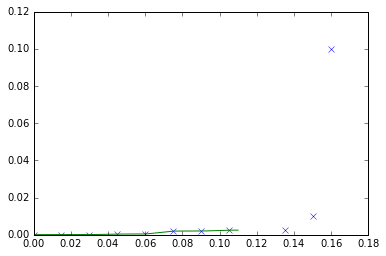

In [17]:
# axial conductance distribution
axial_data, = data_dir.glob('conductivity_data*.csv')
print axial_data

g = conductance.fit_property_from_csv(g, str(axial_data), 'position', 'K', k=1., s=0., plot=True) 

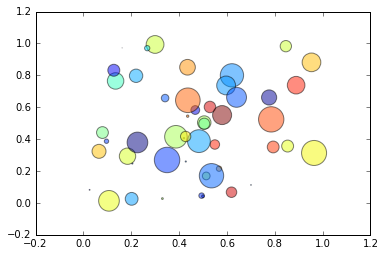

In [18]:
# %load http://matplotlib.org/mpl_examples/shapes_and_collections/scatter_demo.py
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()


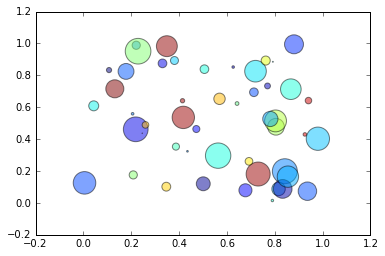

In [19]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radiuses

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()


In [20]:
g = conductance.compute_k(g, k0)

In [21]:
g = flux.flux(g, Jv, psi_e, psi_base, invert_model=True)

In [22]:
# root visitor
def root_visitor(g, v, turtle):
    angles = [130,45]+[30]*5
    n = g.node(v)
    radius = n.radius*1.e4
    order = n.order
    length = n.length*1.e4

    if g.edge_type(v) == '+':
        angle = angles[order]
        turtle.down(angle)


    turtle.setId(v)
    turtle.setWidth(radius)
    for c in n.children():
        if c.edge_type() == '+':
            turtle.rollL(130)

    turtle.F(length)


In [ ]:
import openalea.plantgl.all as pgl
scene = hdisplay.plot(g, has_radius=True, visitor=root_visitor, prop_cmap='psi_out', lognorm=False)
Viewer.display(scene)
pgl.Viewer.widgetGeometry.setSize(450, 600) # set the picture size in px
fn = tempfile.mktemp(suffix='.png')
pgl.Viewer.saveSnapshot(fn)
pgl.Viewer.stop()
img = Image(fn)
os.unlink(fn)
display(img)

> Plot in the Notebook


> Refactoring the model into a function

In [ ]:
from hydroroot.main import hydroroot as hydro

g, surface, volume, Keq, Jv_global = hydro(
    length_data=length_law, 
    axial_conductance_data=axial_conductance_law, 
    radial_conductance_data=radial_conductance_law)

print surface, volume,
print Keq, Jv_global